In [39]:
import os
import shutil
import cv2
import gc
import keras
import numpy as np
import pandas as pd
from keras.applications.mobilenet import MobileNet
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import (BatchNormalization, Dense, Dropout, Flatten)
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
import gradio
import gradio as gr

In [2]:
metadata = pd.read_csv(r"C:\Users\PC\Cookies\Desktop\image_classification\archive (5)\HAM10000_metadata.csv")
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
metadata["dx"].value_counts() / metadata.shape[0]

nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: dx, dtype: float64

In [4]:
image_sample = cv2.imread(r"C:\Users\PC\Cookies\Desktop\image_classification\archive (5)\HAM10000_images_part_1\ISIC_0024306.jpg")
print(image_sample.shape)

(450, 600, 3)


In [5]:
lesion_id_cnt = metadata["lesion_id"].value_counts()
def check_duplicates(id):
    
    if lesion_id_cnt[id] > 1:
        return True
    else:
        return False

metadata["has_duplicate"] = metadata["lesion_id"].map(check_duplicates)

In [6]:
metadata["has_duplicate"].value_counts()

False    5514
True     4501
Name: has_duplicate, dtype: int64

In [7]:
image_folder_1 = r"C:\Users\PC\Cookies\Desktop\image_classification\archive (5)\HAM10000_images_part_1"
image_folder_2 = r"C:\Users\PC\Cookies\Desktop\image_classification\archive (5)\HAM10000_images_part_2"
metadata["folder"] = 0
metadata.set_index("image_id", drop=False, inplace=True)

for image in os.listdir(image_folder_1):
    image_id = image.split(".")[0]
    metadata.loc[image_id, "folder"] = "1"

for image in os.listdir(image_folder_2):
    image_id = image.split(".")[0]
    metadata.loc[image_id, "folder"] = "2"

In [8]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,has_duplicate,folder
image_id,,,,,,,,,
ISIC_0027419,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,True,1
ISIC_0025030,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,True,1
ISIC_0026769,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,True,1
ISIC_0025661,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,True,1
ISIC_0031633,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,True,2


In [9]:
data_train_no_dup, data_val = train_test_split(metadata[metadata["has_duplicate"] == False], test_size=0.36, stratify=metadata[metadata["has_duplicate"] == False]["dx"]) # 36% of the data with no duplicates is roughly 20% of the total
data_train = pd.concat((data_train_no_dup, metadata[metadata["has_duplicate"] == True]), axis=0)
data_val, data_test = train_test_split(data_val, test_size=0.5, stratify=data_val["dx"])
print("Train: " + str(data_train.shape[0] / metadata.shape[0]))
print("Validation: " + str(data_val.shape[0] / metadata.shape[0]))
print("Test: " + str(data_test.shape[0] / metadata.shape[0]))
val_len = data_val.shape[0]
test_len = data_test.shape[0]

Train: 0.801697453819271
Validation: 0.09915127309036445
Test: 0.09915127309036445


In [10]:
base_dir = "base_dir"
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, "image_train")
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, "image_val")
os.mkdir(val_dir)

test_dir = os.path.join(base_dir, "image_test")
os.mkdir(test_dir)

labels = list(metadata["dx"].unique())

for label in labels:
    label_path_train = os.path.join(train_dir, label)
    os.mkdir(label_path_train)
    label_path_val = os.path.join(val_dir, label)
    os.mkdir(label_path_val)
    label_path_test = os.path.join(test_dir, label)
    os.mkdir(label_path_test)

In [11]:
image_dir = r"C:\Users\PC\Cookies\Desktop\image_classification\archive (5)\ham10000_images_part_"

for i in range(data_train.shape[0]):
    image_name = data_train["image_id"][i] + ".jpg"
    src_dir = os.path.join(image_dir + data_train["folder"][i], image_name)
    dst_dir = os.path.join(train_dir, data_train["dx"][i], image_name)
    shutil.copyfile(src_dir, dst_dir)

for i in range(data_val.shape[0]):
    image_name = data_val["image_id"][i] + ".jpg"
    src_dir = os.path.join(image_dir + data_val["folder"][i], image_name)
    dst_dir = os.path.join(val_dir, data_val["dx"][i], image_name)
    shutil.copyfile(src_dir, dst_dir)
    
for i in range(data_test.shape[0]):
    image_name = data_test["image_id"][i] + ".jpg"
    src_dir = os.path.join(image_dir + data_test["folder"][i], image_name)
    dst_dir = os.path.join(test_dir, data_test["dx"][i], image_name)
    shutil.copyfile(src_dir, dst_dir)

In [12]:
for label in labels:
    print(label + " train: " + str(len(os.listdir(os.path.join(train_dir, label)))))
print("\n")
for label in labels:
    print(label + " val: " + str(len(os.listdir(os.path.join(val_dir, label)))))
print("\n")
for label in labels:
    print(label + " val: " + str(len(os.listdir(os.path.join(test_dir, label)))))

bkl train: 940
nv train: 5115
df train: 101
mel train: 1030
vasc train: 119
bcc train: 451
akiec train: 273


bkl val: 80
nv val: 795
df val: 7
mel val: 42
vasc val: 11
bcc val: 31
akiec val: 27


bkl val: 79
nv val: 795
df val: 7
mel val: 41
vasc val: 12
bcc val: 32
akiec val: 27


In [13]:
del data_train_no_dup, metadata
gc.collect()

0

In [14]:
data_gen_param = {
    "rotation_range": 180,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "zoom_range": 0.1,
    "horizontal_flip": True,
    "vertical_flip": True
}
data_generator = ImageDataGenerator(**data_gen_param)
num_images_each_label = 6000

aug_dir = os.path.join(base_dir, "aug_dir")
os.mkdir(aug_dir)

for label in labels:
    
    img_dir = os.path.join(aug_dir, "aug_img")
    os.mkdir(img_dir)
    
    src_dir_label = os.path.join(train_dir, label)
    for image_name in os.listdir(src_dir_label):
        shutil.copy(os.path.join(src_dir_label, image_name), os.path.join(img_dir, image_name))
    
    batch_size = 32
    data_flow_param = {
        "directory": aug_dir,
        "color_mode": "rgb",
        "batch_size": batch_size,
        "shuffle": True,
        "save_to_dir": os.path.join(train_dir, label),
        "save_format": "jpg"
    }
    aug_data_gen = data_generator.flow_from_directory(**data_flow_param)
    
    num_img_aug = num_images_each_label - len(os.listdir(os.path.join(train_dir, label)))
    num_batch = int(num_img_aug / batch_size)
    
    for i in range(0, num_batch):
        next(aug_data_gen)
    
    shutil.rmtree(img_dir)

Found 940 images belonging to 1 classes.
Found 5115 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 1030 images belonging to 1 classes.
Found 119 images belonging to 1 classes.
Found 451 images belonging to 1 classes.
Found 273 images belonging to 1 classes.


In [15]:
for label in labels:
    print(label + " train: " + str(len(os.listdir(os.path.join(train_dir, label)))))
print("\n")
for label in labels:
    print(label + " val: " + str(len(os.listdir(os.path.join(val_dir, label)))))

bkl train: 5896
nv train: 5979
df train: 4747
mel train: 5886
vasc train: 5570
bcc train: 5668
akiec train: 5684


bkl val: 80
nv val: 795
df val: 7
mel val: 42
vasc val: 11
bcc val: 31
akiec val: 27


In [16]:
IMAGE_SHAPE = (224, 224, 3)
data_gen_param = {
    "samplewise_center": True,
    "samplewise_std_normalization": True,
    "rotation_range": 180,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "zoom_range": 0.1,
    "horizontal_flip": True,
    "vertical_flip": True,
    "rescale": 1.0 / 255
}
data_generator = ImageDataGenerator(**data_gen_param)

train_flow_param = {
    "directory": train_dir,
    "batch_size": batch_size,
    "target_size": IMAGE_SHAPE[:2],
    "shuffle": True
}
train_flow = data_generator.flow_from_directory(**train_flow_param)

val_flow_param = {
    "directory": val_dir,
    "batch_size": batch_size,
    "target_size": IMAGE_SHAPE[:2],
    "shuffle": False
}
val_flow = data_generator.flow_from_directory(**val_flow_param)

test_flow_param = {
    "directory": test_dir,
    "batch_size": 1,
    "target_size": IMAGE_SHAPE[:2],
    "shuffle": False
}
test_flow = data_generator.flow_from_directory(**test_flow_param)

Found 39430 images belonging to 7 classes.
Found 993 images belonging to 7 classes.
Found 993 images belonging to 7 classes.


In [17]:
dropout_dense = 0.1

mobilenet_model = MobileNet(input_shape=IMAGE_SHAPE, include_top=False, pooling="max")

model = Sequential()
model.add(mobilenet_model)
model.add(Dropout(dropout_dense))
model.add(BatchNormalization())
model.add(Dense(256, activation="relu"))
model.add(Dropout(dropout_dense))
model.add(BatchNormalization())
model.add(Dense(7, activation="softmax"))

def top_2_acc(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_3_acc(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

model.compile(Adam(0.01), loss="categorical_crossentropy", metrics=[categorical_accuracy, top_2_acc, top_3_acc])

In [18]:
model.save('model.h5')

In [19]:
filepath = "model.h5"

checkpoint_param = {
    "filepath": filepath,
    "monitor": "val_categorical_accuracy",
    "verbose": 1,
    "save_best_only": True,
    "mode": "max"
}
checkpoint = ModelCheckpoint(**checkpoint_param)

lr_decay_params = {
    "monitor": "val_loss",
    "factor": 0.5,
    "patience": 2,
    "min_lr": 1e-5
}
lr_decay = ReduceLROnPlateau(**lr_decay_params)

early_stopping = EarlyStopping(monitor="val_loss", patience=4, verbose=1)

In [20]:
fit_params = {
    "generator": train_flow,
    "steps_per_epoch": data_train.shape[0] // batch_size,
    "epochs": 15,
    "verbose": 1,
    "validation_data": val_flow,
    "validation_steps": data_val.shape[0] // batch_size,
    "callbacks": [checkpoint, lr_decay, early_stopping]
}
print("Training the model...")

history = model.fit_generator(**fit_params)
print("Done!")

Training the model...


C:\Users\PC\AppData\Local\Temp\ipykernel_16504\2706696711.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(**fit_params)


Epoch 1/15
250/250 [==============================] - ETA: 0s - loss: 1.6081 - categorical_accuracy: 0.4153 - top_2_acc: 0.6166 - top_3_acc: 0.7611
Epoch 1: val_categorical_accuracy improved from -inf to 0.04738, saving model to model.h5
250/250 [==============================] - 1451s 6s/step - loss: 1.6081 - categorical_accuracy: 0.4153 - top_2_acc: 0.6166 - top_3_acc: 0.7611 - val_loss: 4.5726 - val_categorical_accuracy: 0.0474 - val_top_2_acc: 0.0938 - val_top_3_acc: 0.2278 - lr: 0.0100
Epoch 2/15
250/250 [==============================] - ETA: 0s - loss: 1.1905 - categorical_accuracy: 0.5408 - top_2_acc: 0.7590 - top_3_acc: 0.8789
Epoch 2: val_categorical_accuracy improved from 0.04738 to 0.45161, saving model to model.h5
250/250 [==============================] - 1459s 6s/step - loss: 1.1905 - categorical_accuracy: 0.5408 - top_2_acc: 0.7590 - top_3_acc: 0.8789 - val_loss: 1.5309 - val_categorical_accuracy: 0.4516 - val_top_2_acc: 0.6804 - val_top_3_acc: 0.8377 - lr: 0.0100
Epoch

In [21]:
_, val_acc, val_top_2_acc, val_top_3_acc = model.evaluate_generator(val_flow, steps=len(val_flow))
y_val_true = val_flow.classes
y_val_pred = np.argmax(model.predict_generator(val_flow, steps=len(val_flow)), axis=1)
val_f1_score = f1_score(y_val_true, y_val_pred, average="micro")

print("Validation accuracy: {:.4f}".format(val_acc))
print("Validation top-2 accuracy: {:.4f}".format(val_top_2_acc))
print("Validation top-3 accuracy: {:.4f}".format(val_top_3_acc))
print("Validation F1 score: {:.4f}".format(val_f1_score))

C:\Users\PC\AppData\Local\Temp\ipykernel_16504\745493592.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, val_acc, val_top_2_acc, val_top_3_acc = model.evaluate_generator(val_flow, steps=len(val_flow))
C:\Users\PC\AppData\Local\Temp\ipykernel_16504\745493592.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_val_pred = np.argmax(model.predict_generator(val_flow, steps=len(val_flow)), axis=1)


Validation accuracy: 0.8409
Validation top-2 accuracy: 0.9315
Validation top-3 accuracy: 0.9789
Validation F1 score: 0.8439


In [22]:
loss_train = history.history["loss"]
acc_train = history.history["categorical_accuracy"]
loss_val = history.history["val_loss"]
acc_val = history.history["val_categorical_accuracy"]
epochs = np.arange(1, len(loss_train) + 1)

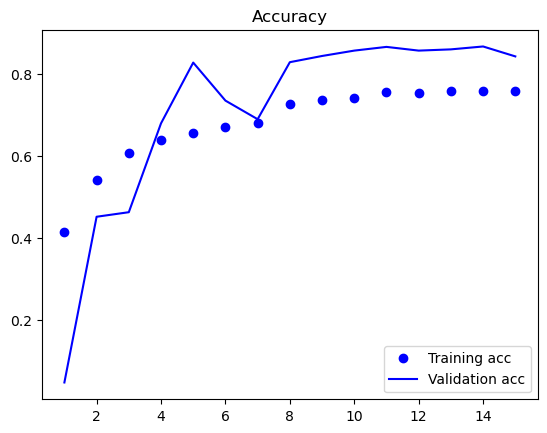

In [23]:
plt.plot(epochs, acc_train, "bo", label="Training acc")
plt.plot(epochs, acc_val, "b", label="Validation acc")
plt.title("Accuracy")
plt.legend()
plt.show()

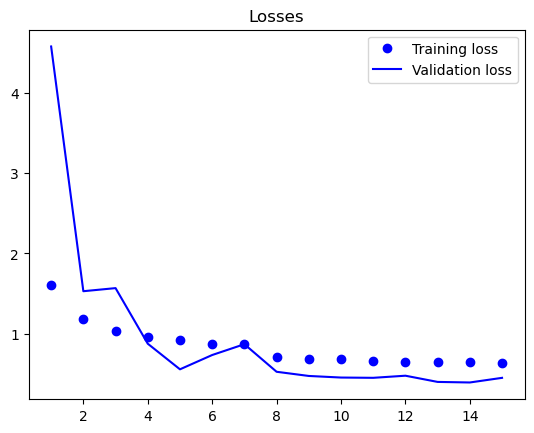

In [24]:
plt.plot(epochs, loss_train, "bo", label="Training loss")
plt.plot(epochs, loss_val, "b", label="Validation loss")
plt.title("Losses")
plt.legend()
plt.show()

In [25]:
y_test_true = val_flow.classes
y_test_pred = np.argmax(model.predict_generator(test_flow, steps = len(test_flow)), axis = 1)

C:\Users\PC\AppData\Local\Temp\ipykernel_16504\296674130.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_test_pred = np.argmax(model.predict_generator(test_flow, steps = len(test_flow)), axis = 1)


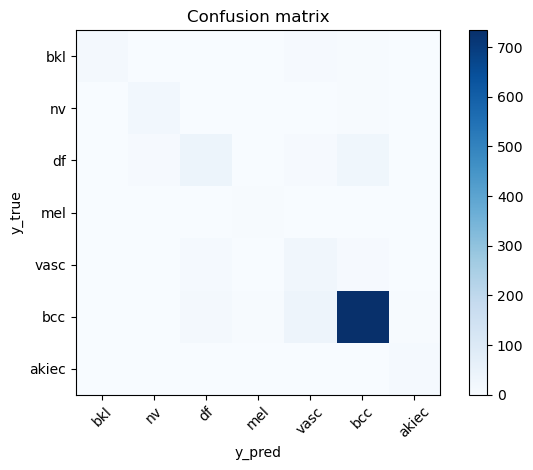

In [26]:
conf_mat = confusion_matrix(y_test_true, y_test_pred)
plt.imshow(conf_mat, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel("y_true")
plt.xlabel("y_pred")
plt.tight_layout()

In [35]:
model.save('model1.h5')